# Coding exercise for Wang Lab
### Implementation of nnU-net for the segmentation of pancreas and pancreatic lesions on CT scan, with classication of the pancreatic lesions
### by Leo Chen
### August/September 2024

In [1]:
### IMPORTS
import os
import glob
#import util

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.init as init

from collections import defaultdict
from collections import Counter

from datetime import datetime

import SimpleITK as sitk
#import nibabel as nib

import json
import shutil

In [2]:
# check if cuda is working
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()

0

In [3]:
### GLOBAL VARIABLES

# using GPU?
gpu = False


# directories where the files are
traindir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\train'
valdir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation'
testdir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\test'

csvpath = r'C:\Users\Leo\OneDrive\Documents\GitHub\WangLabQuiz\csv files\trainval_metadata.csv'   # csv with the image dimensions, image and mask file paths

nnUNet_raw_dir = r'C:\Users\Leo\OneDrive\Documents\UHN-MedImg3D-ML-quiz\nnUnet_raw'

In [4]:
### FUNCTIONS FOR SITK and IMAGE AUGMENTATION

def rotateImage(original, anglex, angley, anglez, interpolate='linear'):
    """ Returns the 'rotated' 3d image about the physical center that is resampled based on the 'original' image
    1. original - original image 
    2. angle x is roll / twisting the body like a rolling pin, turning in dance
    3. angle y is yaw / rotating the body like a propeller blade, like break dancing
    4. angle z - pitch / tilt along the superior/inferior axis (i.e trendelenburg)
    
    """

    if interpolate == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolate == 'NN':
        interpolator = sitk.sitkNearestNeighbor

    radx = anglex * math.pi / 180
    rady = angley * math.pi / 180
    radz = anglez * math.pi / 180

    origin = np.array(original.GetOrigin())
    pixelcenter = np.array(sitk.GetSize(original)) / 2.
    physicalcenter = sitk.TransformContinuousIndexToPhysicalPoint(pixelcenter)

    transform = sitk.Euler3DTransform()
    transform.SetCenter(physicalcenter)
    transform.SetRotation(radz, rady, radx)    # note the order is z, y, x

    unitvecs = np.transpose(np.reshape(original.GetDirection(), (-1, 3)))
    #print(unitvecs)
    matrix = np.reshape(transform.GetMatrix(), (-1, 3))
    inverse = np.linalg.inv(matrix)


    # the transform matrix is actually mapping backwards: post to pre
    # therefore the forward transformation is the inverse matrix
    transformedunitvecs = inverse @ unitvecs   # new i, j, k are columns
    #print(transformedunitvecs)
    newdirection = transformedunitvecs.flatten('F')    # flatten by column

    print(newdirection)
    neworigin = (matrix @ (origin - physicalcenter)) + physicalcenter

    rotatedImage = sitk.Resample(original, original, transform, interpolator)
    rotatedImage.SetDirection(newdirection)
    rotatedImage.SetOrigin(neworigin)

    return rotatedImage

def flipImage(original):
    """Flips an SimpleITK over left/right axis"""
    flipped = sitk.Flip(original, [True, False, False])
    return flipped

def flipslice(original):
    """Flips a numpy slice (2d image) """
    # flips 2D slice (reverses x indices)
    flipped = np.flipud(original)  #np.fliplr(original)
    return flipped

def bbox_3D(img):
    """Finds the bounding box around a 3D image (numpy)
    returns rmin, rmax, cmin, cmax, zmin, zmax (r = row, c = column)"""
    try:    
        z = np.any(img, axis=(1, 2))    #z
        c = np.any(img, axis=(0, 1))    #x , (c = column)
        r = np.any(img, axis=(0, 2))    #y , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
        zmin, zmax = np.where(z)[0][[0, -1]]

        #x min max, y min max, z min max
        return [rmin, rmax, cmin, cmax, zmin, zmax]
    except:
        return -1, -1, -1, -1, -1, -1


def bbox_2D(img):
    """Finds the bounding box around a 2D image (numpy)
    returns rmin, rmax, cmin, cmax (r = row, c = column)
    If no elements exist, then returns (-1, -1, -1, -1)"""
    
    try:
        c = np.any(img, axis=0)    #y , (c = column)
        r = np.any(img, axis=1)    #x , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
    
        return rmin, rmax, cmin, cmax
    except:
        return -1, -1, -1, -1


def cropImage(image, threshold, xshift, yshift):
    """Crops SimpleITK image to remove pixels below a threshold (e.g. black space)
    Can also shift by *xshift and *yshift (random shifts in pixels) for augmentation"""
    # load image
    npy = sitk.GetArrayFromImage(image)

    # GET METADATA
    direction = image.GetDirection()
    spacing = image.GetSpacing()

    # CALCULATE BOUNDING BOX OF BODY (removes black space)
    mask = npy > threshold
    [xmin, xmax, ymin, ymax, zmin, zmax] = bbox_3D(mask)

    # check to make sure shifts do not extend outside boundaries of image
    if xmin + xshift < 0 or xmax + xshift > npy.shape[2]:
        xshift = 0

    if ymin + yshift < 0 or ymax + yshift > npy.shape[1]:
        yshift = 0

    # CROP IMAGE
    newnpy = npy[zmin:zmax, (ymin+yshift):(ymax+yshift), (xmin+xshift):(xmax+xshift)]

    newimage = sitk.GetImageFromArray(newnpy)
    topleft = [int(xmin+xshift), int(ymin+yshift), zmin]
    neworigin = image.TransformIndexToPhysicalPoint(topleft)

    newimage.SetOrigin(neworigin)
    newimage.SetDirection(direction)
    newimage.SetSpacing(spacing)

    return newimage


def squareImage(image):
    """Makes an SimpleITK image square by padding with zeros
    (square meaning width = height)"""
    [numcols, numrows, numslices] = image.GetSize()
    npy = sitk.GetArrayFromImage(image)

    if numcols < numrows:    #pad columns
        numzerostopad = numrows - numcols
        leftpad = int(numzerostopad / 2)
        rightpad = numzerostopad - leftpad

        newnpy = np.concatenate((np.zeros([numslices, numrows, leftpad]), npy, np.zeros([numslices, numrows, rightpad])), axis=2)

        topleft = [-leftpad, 0, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    elif numrows <= numcols:  #pad rows
        numzerostopad = numcols - numrows
        toppad = int(numzerostopad / 2)
        botpad = numzerostopad - toppad

        newnpy = np.concatenate((np.zeros([numslices, toppad, numcols]), npy, np.zeros([numslices, botpad, numcols])), axis=1)

        topleft = [0, -toppad, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    paddedimg = sitk.GetImageFromArray(newnpy)
    paddedimg.SetOrigin(neworigin)
    paddedimg.SetDirection(image.GetDirection())
    paddedimg.SetSpacing(image.GetSpacing())

    return paddedimg

def resampleImage(image, finalsize, interpolation='linear'):
    """Resamples SimpleITK image to finalsize x finalsize (width and height in pixels)
    Preserves the original physical size of the image and number of slices
    Changes the resolution so that the new image has numslices x *finalsize x *finalsize dimensions"""
    
    size = image.GetSize()
    numslices = size[2]
    squaresize = size[1]

    # RESAMPLE TO finalsize x finalsize
    finalnpy = np.zeros([numslices, finalsize, finalsize])
    reference = sitk.GetImageFromArray(finalnpy)
    reference.SetOrigin(image.GetOrigin())
    reference.SetDirection(image.GetDirection())

    spacing = image.GetSpacing()
    newspacing = np.zeros(3)
    newspacing[0:2] = (squaresize - 1) * np.array(spacing[0:2]) / (finalsize - 1)
    newspacing[2] = spacing[2]
    reference.SetSpacing(newspacing)


    # MAKING RESAMPLING FILTER
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolation == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolation == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    # RESAMPLE TO finalsize x finalsize x n
    resampledimg = resample.Execute(image)

    return resampledimg


def projectImage(reference, moving, interpolate = 'linear'):
    """Projects an SimpleITK image (*moving onto *reference)
    interpolate* = linear or NN (nearest neighbor)"""
    
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolate == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolate == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    resampledimg = resample.Execute(moving)

    return resampledimg


def resampleImageToVoxelSize(image, voxelx, voxely, voxelz, interpolation='linear'):
    """Resamples SimpleITK *image* to spacing *[voxelx, voxely, voxelz] in mm
    Preserves the original physical size of the image
    *voxelz is slice thickness (usually)
    *voxelx and *voxely are voxel width and height, respectively
    """
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_spacing = [voxelx, voxely, voxelz]
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    # new dimension will be original size * original spacing / new spacing
    # based on physical distance formula: 
    #    original size (pixel) * original spacing (mm / pixel) = new size (pixel) * new spacing (mm / pixel)
    
    if interpolation == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolation == 'NN':
        interpolator = sitk.sitkNearestNeighbor
    
    # creates new image
    new_image = sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())
    
    return new_image


def windowImage(image, window_width, window_center, output_min=0, output_max=255):
    """Normalizes SimpleITK *image* (CT scan) based on window specification
    (example, abdominal soft tissue window is W = 400, C = 50, or -350 to 450)
    Clips values above 0 and 1
    """
    
    window_min = window_center - window_width / 2
    window_max = window_center + window_width / 2
    
    output_min = 0
    output_max = 255
    
    windowed_image = sitk.IntensityWindowing(image, window_min, window_max, output_min, output_max)
    
    return windowed_image
    


### dataset.json

In [5]:
raw_folder = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUnet_raw'
data_folder = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUnet_raw\Dataset002_PancreasLesion'


In [6]:
from nnunetv2.training.dataloading.data_loader_3d_classify import nnUNetDataLoader3Dclassify
from nnunetv2.training.dataloading.data_loader_2d_classify import nnUNetDataLoader2Dclassify
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager, ConfigurationManager
from nnunetv2.training.dataloading.nnunet_dataset_classify import nnUNetDatasetClassify
from nnunetv2.utilities.label_handling.label_handling import LabelManager
from batchgenerators.utilities.file_and_folder_operations import load_json, join
from nnunetv2.training.dataloading.base_data_loader_classify import nnUNetDataLoaderBaseClassify
from nnunetv2.training.dataloading.nnunet_dataset_classify import nnUNetDatasetClassify

import numpy as np

In [7]:


#folder = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_preprocessed\Dataset002_PancreasLesion\nnUNetPlans_3d_fullres'
folder = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_preprocessed\Dataset002_PancreasLesion\nnUNetPlans_2d'
ds = nnUNetDatasetClassify(folder, None, 0)


nnUNet_preprocessed = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_preprocessed\Dataset002_PancreasLesion'
dataset_json = load_json(r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_preprocessed\Dataset002_PancreasLesion\dataset.json')

plans = load_json(join(nnUNet_preprocessed, 'ClassifyinnUNetPlans.json'))

plans_manager = PlansManager(plans)

label_manager = plans_manager.get_label_manager(dataset_json)



In [8]:
print(plans)

{'dataset_name': 'Dataset002_PancreasLesion', 'plans_name': 'classifyinnUNetPlans', 'original_median_spacing_after_transp': [2.0, 0.73046875, 0.73046875], 'original_median_shape_after_transp': [64, 119, 178], 'image_reader_writer': 'SimpleITKIO', 'transpose_forward': [0, 1, 2], 'transpose_backward': [0, 1, 2], 'configurations': {'2d': {'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 132, 'patch_size': [128, 192], 'median_image_size_in_voxels': [118.0, 181.0], 'spacing': [0.73046875, 0.73046875], 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_data_or_seg_to_shape', 'resa

In [12]:
dl = nnUNetDataLoaderBaseClassify(data=ds,
                                  batch_size=2,
                                  patch_size=[128, 192],
                                  final_patch_size= [128, 192],
                                  label_manager=label_manager
                                  )

print(dl)

In [13]:


dl2D = nnUNetDataLoader2Dclassify(data=ds,
                                  batch_size=2,
                                  patch_size=[128, 192],
                                  final_patch_size= [128, 192],
                                  label_manager=label_manager
                                  )

In [54]:
dict = dl2D.generate_train_batch()

(2, 1, 128, 192)
(2, 1, 128, 192)


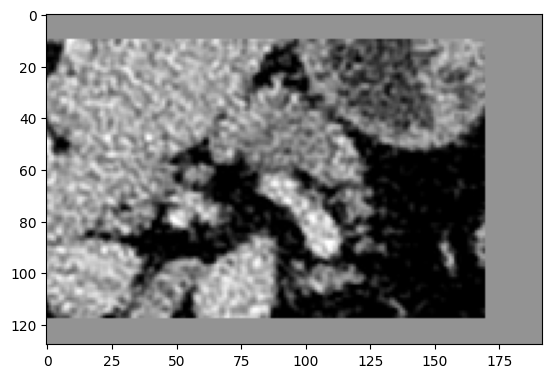

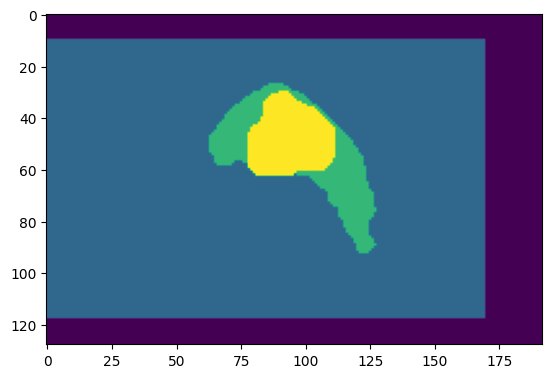

In [55]:
data = dict['data']
segs = dict['target']

print(data.shape)
print(segs.shape)

i = 1

plt.figure()
plt.imshow(data[i, 0], cmap='gray')
plt.figure()
plt.imshow(segs[i, 0])

In [11]:
import numpy as np
import torch
from threadpoolctl import threadpool_limits

from nnunetv2.training.dataloading.base_data_loader_classify import nnUNetDataLoaderBaseClassify
from nnunetv2.training.dataloading.nnunet_dataset_classify import nnUNetDatasetClassify


class nnUNetDataLoader2Dclassify(nnUNetDataLoaderBaseClassify):
    def generate_train_batch(self):
        selected_keys = self.get_indices()
        # preallocate memory for data and seg
        data_all = np.zeros(self.data_shape, dtype=np.float32)
        seg_all = np.zeros(self.seg_shape, dtype=np.int16)
        lesion_all = np.zeros(len(selected_keys))

        case_properties = []

        for j, current_key in enumerate(selected_keys):
            # oversampling foreground will improve stability of model training, especially if many patches are empty
            # (Lung for example)
            #force_fg = self.get_do_oversample(j)
            force_fg = True


            data, seg, properties, lesion = self._data.load_case(current_key)
            case_properties.append(properties)

            # select a class/region first, then a slice where this class is present, then crop to that area
            if not force_fg:
                if self.has_ignore:
                    selected_class_or_region = self.annotated_classes_key if (
                            len(properties['class_locations'][self.annotated_classes_key]) > 0) else None
                else:
                    selected_class_or_region = None
            else:
                # filter out all classes that are not present here
                #eligible_classes_or_regions = [i for i in properties['class_locations'].keys() if len(properties['class_locations'][i]) > 0]
                eligible_classes_or_regions = [2]

                # if we have annotated_classes_key locations and other classes are present, remove the annotated_classes_key from the list
                # strange formulation needed to circumvent
                # ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
                tmp = [i == self.annotated_classes_key if isinstance(i, tuple) else False for i in eligible_classes_or_regions]
                if any(tmp):
                    if len(eligible_classes_or_regions) > 1:
                        eligible_classes_or_regions.pop(np.where(tmp)[0][0])

                selected_class_or_region = eligible_classes_or_regions[np.random.choice(len(eligible_classes_or_regions))] if \
                    len(eligible_classes_or_regions) > 0 else None

            if selected_class_or_region is not None:
                selected_slice = np.random.choice(properties['class_locations'][selected_class_or_region][:, 1])
            else:
                selected_slice = np.random.choice(len(data[0]))

            data = data[:, selected_slice]
            seg = seg[:, selected_slice]

            # the line of death lol
            # this needs to be a separate variable because we could otherwise permanently overwrite
            # properties['class_locations']
            # selected_class_or_region is:
            # - None if we do not have an ignore label and force_fg is False OR if force_fg is True but there is no foreground in the image
            # - A tuple of all (non-ignore) labels if there is an ignore label and force_fg is False
            # - a class or region if force_fg is True
            class_locations = {
                selected_class_or_region: properties['class_locations'][selected_class_or_region][properties['class_locations'][selected_class_or_region][:, 1] == selected_slice][:, (0, 2, 3)]
            } if (selected_class_or_region is not None) else None

            # print(properties)
            shape = data.shape[1:]
            dim = len(shape)
            bbox_lbs, bbox_ubs = self.get_bbox(shape, force_fg if selected_class_or_region is not None else False,
                                               class_locations, overwrite_class=selected_class_or_region)


            # whoever wrote this knew what he was doing (hint: it was me). We first crop the data to the region of the
            # bbox that actually lies within the data. This will result in a smaller array which is then faster to pad.
            # valid_bbox is just the coord that lied within the data cube. It will be padded to match the patch size
            # later
            valid_bbox_lbs = [max(0, bbox_lbs[i]) for i in range(dim)]
            valid_bbox_ubs = [min(shape[i], bbox_ubs[i]) for i in range(dim)]

            # At this point you might ask yourself why we would treat seg differently from seg_from_previous_stage.
            # Why not just concatenate them here and forget about the if statements? Well that's because segneeds to
            # be padded with -1 constant whereas seg_from_previous_stage needs to be padded with 0s (we could also
            # remove label -1 in the data augmentation but this way it is less error prone)
            this_slice = tuple([slice(0, data.shape[0])] + [slice(i, j) for i, j in zip(valid_bbox_lbs, valid_bbox_ubs)])
            data = data[this_slice]

            this_slice = tuple([slice(0, seg.shape[0])] + [slice(i, j) for i, j in zip(valid_bbox_lbs, valid_bbox_ubs)])
            seg = seg[this_slice]

            padding = [(-min(0, bbox_lbs[i]), max(bbox_ubs[i] - shape[i], 0)) for i in range(dim)]
            data_all[j] = np.pad(data, ((0, 0), *padding), 'constant', constant_values=0)
            seg_all[j] = np.pad(seg, ((0, 0), *padding), 'constant', constant_values=-1)
            lesion_all[j] = int(lesion)

        if self.transforms is not None:
            with torch.no_grad():
                with threadpool_limits(limits=1, user_api=None):

                    data_all = torch.from_numpy(data_all).float()
                    seg_all = torch.from_numpy(seg_all).to(torch.int16)
                    lesion_all = torch.from_numpy(lesion_all).type(torch.LongTensor)

                    images = []
                    segs = []
                    for b in range(self.batch_size):
                        tmp = self.transforms(**{'image': data_all[b], 'segmentation': seg_all[b]})
                        images.append(tmp['image'])
                        segs.append(tmp['segmentation'])
                    data_all = torch.stack(images)
                    if isinstance(segs[0], list):
                        seg_all = [torch.stack([s[i] for s in segs]) for i in range(len(segs[0]))]
                    else:
                        seg_all = torch.stack(segs)
                    del segs, images

            return {'data': data_all, 'target': seg_all, 'keys': selected_keys, 'lesion_class': lesion_all}

        return {'data': data_all, 'target': seg_all, 'keys': selected_keys, 'lesion_class': lesion_all}


#if __name__ == '__main__':
#    folder = '/media/fabian/data/nnUNet_preprocessed/Dataset004_Hippocampus/2d'
#    ds = nnUNetDataset(folder, None, 1000)  # this should not load the properties!
#    dl = nnUNetDataLoader2D(ds, 366, (65, 65), (56, 40), 0.33, None, None)
#    a = next(dl)


IndexError: index 2 is out of bounds for axis 0 with size 2

In [47]:
print(i)
print(bbox_lbs, bbox_ubs)

pancreas_locs = properties['class_locations'][1]
lesion_locs = properties['class_locations'][2]

quiz_1_034
[21, -8, -12] [85, 120, 180]


In [49]:
print(pancreas_locs[0])

[ 0 37 51 13]


In [48]:
print(pancreas_locs.shape)
print(lesion_locs.shape)
print(data.shape)
print(seg.shape)

(10000, 4)
(10000, 4)
(1, 75, 113, 169)
(1, 75, 113, 169)


In [5]:
dict = dl3D.generate_train_batch()

In [6]:
for key, value in dict.items():
    print(key)

data
target
keys
lesion_class


In [10]:
data = dict['data']
target = dict['target']
keys = dict['keys']
lesion_class = dict['lesion_class']

In [8]:
print(keys)
print(lesion_class)

['quiz_1_516' 'quiz_1_025' 'quiz_0_313']
[1. 1. 0.]


In [14]:
print(data.shape)
print(target.shape)

(3, 1, 64, 128, 192)
(3, 1, 64, 128, 192)
1.0


In [12]:
img = data[0, 0, :]
seg = target[0, 0, :]

In [3]:
pickle_path = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\nnUNet_preprocessed\Dataset002_PancreasLesion\nnUNetPlans_3d_fullres\quiz_0_041.pkl'

pickle = pd.read_pickle(pickle_path)

In [4]:
print(pickle)

{'sitk_stuff': {'spacing': (0.7049999833106995, 0.7049999833106995, 0.801025390625), 'origin': (-164.0625, -180.4687042236328, 1647.5), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)}, 'spacing': [0.801025390625, 0.7049999833106995, 0.7049999833106995], 'shape_before_cropping': (106, 116, 161), 'bbox_used_for_cropping': [[0, 106], [0, 116], [0, 161]], 'shape_after_cropping_and_before_resampling': (106, 116, 161), 'class_locations': {1: array([[ 0, 33, 45, 55],
       [ 0, 29, 25, 22],
       [ 0, 24, 25, 38],
       ...,
       [ 0, 27, 55, 34],
       [ 0,  8, 38, 70],
       [ 0, 35, 44, 28]], dtype=int64), 2: array([[ 0, 30, 39, 51],
       [ 0, 34, 43, 31],
       [ 0, 34, 43, 28],
       ...,
       [ 0, 30, 41, 37],
       [ 0, 29, 36, 27],
       [ 0, 28, 53, 38]], dtype=int64)}}


In [11]:
class_locations = pickle['class_locations']


In [12]:
print(class_locations)


{1: array([[ 0, 33, 45, 55],
       [ 0, 29, 25, 22],
       [ 0, 24, 25, 38],
       ...,
       [ 0, 27, 55, 34],
       [ 0,  8, 38, 70],
       [ 0, 35, 44, 28]], dtype=int64), 2: array([[ 0, 30, 39, 51],
       [ 0, 34, 43, 31],
       [ 0, 34, 43, 28],
       ...,
       [ 0, 30, 41, 37],
       [ 0, 29, 36, 27],
       [ 0, 28, 53, 38]], dtype=int64)}


In [13]:
eligible_classes_or_regions = [i for i in class_locations.keys() if len(class_locations[i]) > 0]

print(eligible_classes_or_regions)

[1, 2]
